### Predicting credit card fraud transaction using machine learning.

#### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. however this project is meant to address this by predicting wether a credit card transaction is fraudulent or not(i.e a classification problem).

- 1 = Fraudulent
- 0 = Non Fraudulent

#### Content of data
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 
Data was gotten from kaggle at: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv
the features are not explained probably due to company's data privacy.

#### Proof of concept
if we can reach a recall of 90percent and above. we will pursue this project.

- recall: this explains how many of the actual predicted fraudulent cases did the model catch(especially useful in fraud cases)
- precision: when the model predicts a fraudulent case, how often is it correct.
- f1-score: it balances precision and recall

### NOTE

- Perfect Model/Classifiers Are Rare in Real Life due to ❌ Noise & Errors in Data

- Real-world data has measurement errors, missing values, and inconsistencies due to ❌ Overlapping Class Distributions

- Many real problems (e.g., fraud detection, medical diagnoses) have features that overlap, making it impossible to separate classes 100%.
❌ Concept Drift

- In dynamic environments (e.g., finance, cybersecurity), the patterns change over time, making past perfect models useless. Hence the need to always check for model performnce and retrain if need be.


In [1]:
#!pip install xgboost

In [2]:
#!pip install imblearn

In [3]:
# import Eda libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import seaborn as sns
import numpy as np

# Import libraries for balancing imbalanced classification
from imblearn.over_sampling import SMOTE 
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Import models
import sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

# Model evaluators
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# print last-updated
import datetime
print(f"Notebook was last updated: {datetime.datetime.now()}")

# Print versions of libraries we are using
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Seaborn: {seaborn.__version__}")

Notebook was last updated: 2025-02-28 11:34:12.138284
Numpy version: 2.2.2
Pandas version: 2.2.3
Sklearn version: 1.6.1
Seaborn: 0.13.2


In [4]:
# Load the dataset
df = pd.read_csv("creditcard.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


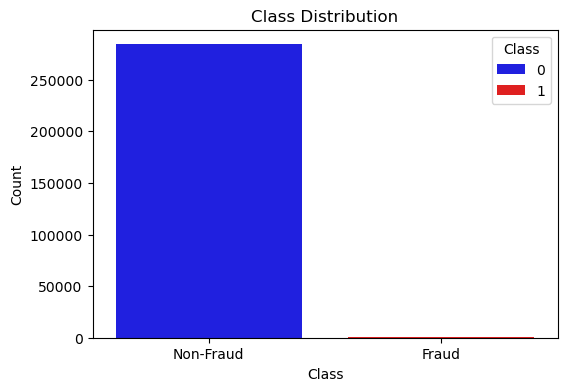

In [6]:
# Check class distribution
class_counts = df["Class"].value_counts()

# Plot class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values,hue=class_counts.index, palette=["blue", "red"])
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [7]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

##### The dataset is highly imbalanced, meaning that a standard classifier would likely be biased towards the majority class.
Class Distribution:
- Non-Fraud (0): 99.83%
- Fraud (1): 0.17%

In [8]:
print(df.isnull().sum().sum()) # no missing value

0


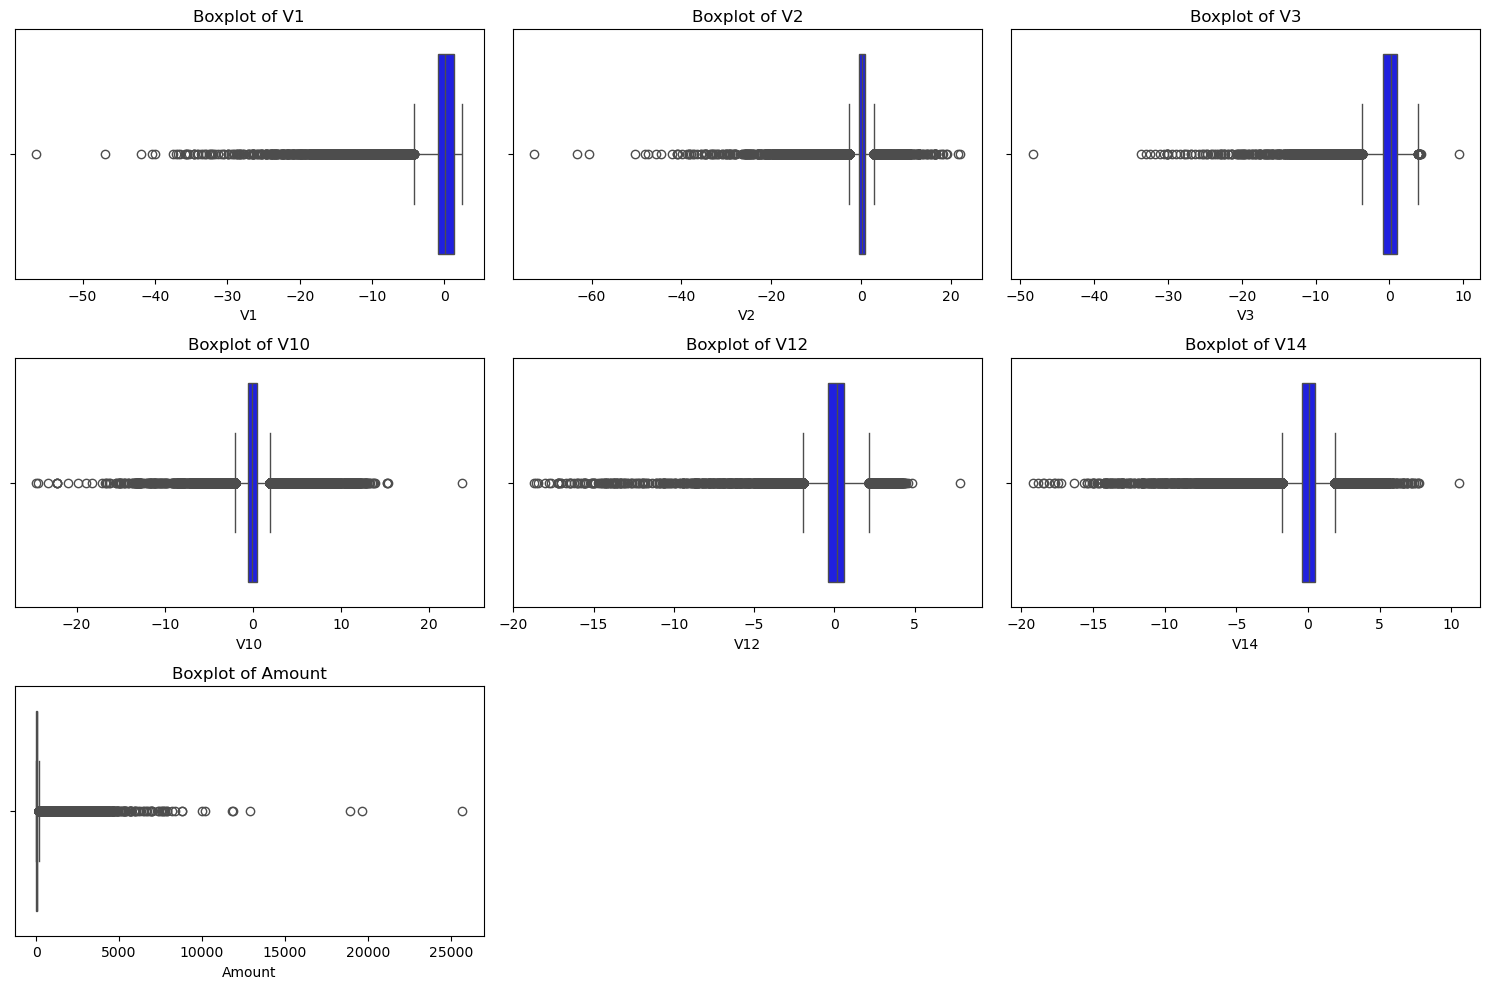

In [9]:
# Detect outliers using boxplots for selected features
plt.figure(figsize=(15, 10))
selected_features = ["V1", "V2", "V3", "V10", "V12", "V14", "Amount"]

for i, feature in enumerate(selected_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[feature], color="blue")
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

In [10]:
# split data into train and valid and test

# First, split into training (80%) and remain (20%)
train, temp = train_test_split(df, test_size=0.2, random_state=42)

# Then, split the remaining 20% into validation (10%) and test (10%)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)  # 10% each

# Save to CSV to avoid data leakage
train.to_csv("credit_train.csv", index=False) # training data
valid.to_csv("credit_valid.csv", index=False) # Validation data
test.to_csv("credit_test.csv", index=False) # testing data


In [11]:
train_df = pd.read_csv("credit_train.csv")

In [12]:
train_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
1,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0


In [13]:
train_df.describe() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94792.551673,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,...,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,88.479993,0.001729
std,47488.471663,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,...,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,254.930277,0.041548
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54161.000000,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,...,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,5.600000,0.000000
50%,84707.000000,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,...,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,22.000000,0.000000
75%,139305.000000,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,...,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,77.100000,0.000000
max,172792.000000,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [14]:
train_df["Class"].value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [15]:
# using smote sampling method 
x = train_df.drop(columns=["Class"])# Define features and target
y = train_df["Class"]

# Print class distribution before SMOTE
print("Before SMOTE:", Counter(y))

Before SMOTE: Counter({0: 227451, 1: 394})


In [16]:
# Reduce majority class using RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.9, random_state=42)  # Reduce non-fraud cases
x_resampled, y_resampled = rus.fit_resample(x, y)

print("After Random Undersampling:", Counter(y_resampled))

After Random Undersampling: Counter({0: 437, 1: 394})


In [17]:
print("After SMOTE:", Counter(y_resampled))

After SMOTE: Counter({0: 437, 1: 394})


In [18]:
x_resampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
35957,69950.0,1.284213,-0.501464,-0.357034,-2.105217,-0.438960,-1.008206,0.096926,-0.295436,1.930483,...,0.063061,-0.202416,-0.393263,-0.207654,-0.405794,0.817223,-0.851350,0.059367,0.023643,57.01
195897,149502.0,0.155404,-0.039331,-0.563432,-0.478156,0.985475,0.859321,0.577935,0.379662,0.023975,...,-0.134477,0.507181,1.405727,0.137711,-1.434481,-0.521119,-0.049328,0.049098,-0.030566,87.53
131856,70393.0,1.135878,0.029953,0.323076,1.133289,-0.174560,0.004576,-0.148293,0.061964,0.283051,...,-0.118918,0.195802,0.553511,-0.213152,-0.424880,0.640881,-0.125404,0.034163,0.021453,43.66
142580,165837.0,1.992833,0.144782,-1.618801,1.410094,0.373586,-1.152419,0.642564,-0.402493,0.258189,...,-0.289128,0.056648,0.332903,-0.013404,-0.017312,0.438219,-0.490139,-0.020661,-0.059648,27.00
213618,164684.0,-0.385451,0.672831,0.987344,-0.948938,0.740487,-0.150095,1.075317,-0.279940,0.370106,...,-0.047132,0.008414,0.307288,-0.567814,0.657006,1.060964,0.270908,-0.389675,-0.300019,10.00


In [19]:
x_resampled["Class"] = y_resampled

In [20]:
x_resampled.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
35957,69950.0,1.284213,-0.501464,-0.357034,-2.105217,-0.438960,-1.008206,0.096926,-0.295436,1.930483,...,-0.202416,-0.393263,-0.207654,-0.405794,0.817223,-0.851350,0.059367,0.023643,57.01,0
195897,149502.0,0.155404,-0.039331,-0.563432,-0.478156,0.985475,0.859321,0.577935,0.379662,0.023975,...,0.507181,1.405727,0.137711,-1.434481,-0.521119,-0.049328,0.049098,-0.030566,87.53,0


In [21]:
x_resampled["Class"].value_counts()

Class
0    437
1    394
Name: count, dtype: int64

In [22]:
# checking for feature correlation
corr_matrix = x_resampled.corr()
corr_matrix

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.217579,-0.214898,0.137558,-0.206110,0.282256,0.106188,0.214629,-0.134544,0.167232,...,-0.074466,0.118186,0.044322,0.042793,-0.158727,-0.030895,-0.122894,-0.018559,-0.005837,-0.170088
V1,0.217579,1.000000,-0.691791,0.857297,-0.592584,0.806183,0.361037,0.855190,-0.125444,0.608967,...,-0.006544,-0.058691,-0.085850,-0.079584,-0.101944,0.021411,0.125013,0.228211,-0.070984,-0.420214
V2,-0.214898,-0.691791,1.000000,-0.816752,0.632908,-0.775774,-0.266502,-0.794510,0.050656,-0.680618,...,0.128959,-0.070486,-0.057409,-0.032307,-0.005694,-0.051807,-0.220304,0.072976,-0.230455,0.486777
V3,0.137558,0.857297,-0.816752,1.000000,-0.765440,0.833637,0.489289,0.885494,-0.216514,0.751570,...,-0.013496,-0.069797,-0.018309,0.024275,-0.046962,-0.034579,0.082313,0.127825,-0.013535,-0.573032
V4,-0.206110,-0.592584,0.632908,-0.765440,1.000000,-0.554683,-0.475038,-0.702018,0.138114,-0.768389,...,0.022665,0.097055,0.013504,-0.085193,-0.034440,0.157321,0.027528,-0.053498,0.020638,0.723577
V5,0.282256,0.806183,-0.775774,0.833637,-0.554683,1.000000,0.307320,0.826429,-0.260797,0.647498,...,-0.018619,-0.083623,-0.066586,-0.107358,-0.055129,0.085802,0.211019,0.143401,-0.097492,-0.377131
V6,0.106188,0.361037,-0.266502,0.489289,-0.475038,0.307320,1.000000,0.332479,-0.534153,0.386454,...,0.047631,-0.022022,0.227126,-0.007653,-0.121020,-0.088476,-0.187558,-0.003392,0.121218,-0.407093
V7,0.214629,0.855190,-0.794510,0.885494,-0.702018,0.826429,0.332479,1.000000,0.021098,0.744668,...,-0.016540,-0.095535,0.037994,-0.036392,0.106406,0.026272,0.200471,0.138826,0.090509,-0.491511
V8,-0.134544,-0.125444,0.050656,-0.216514,0.138114,-0.260797,-0.534153,0.021098,1.000000,-0.138909,...,-0.137390,0.066149,-0.270742,0.075568,0.202945,0.046912,0.232539,-0.002705,0.019259,0.074949
V9,0.167232,0.608967,-0.680618,0.751570,-0.768389,0.647498,0.386454,0.744668,-0.138909,1.000000,...,0.081520,-0.198605,0.005369,0.012236,0.006584,-0.128732,0.102002,0.078200,0.034387,-0.568092


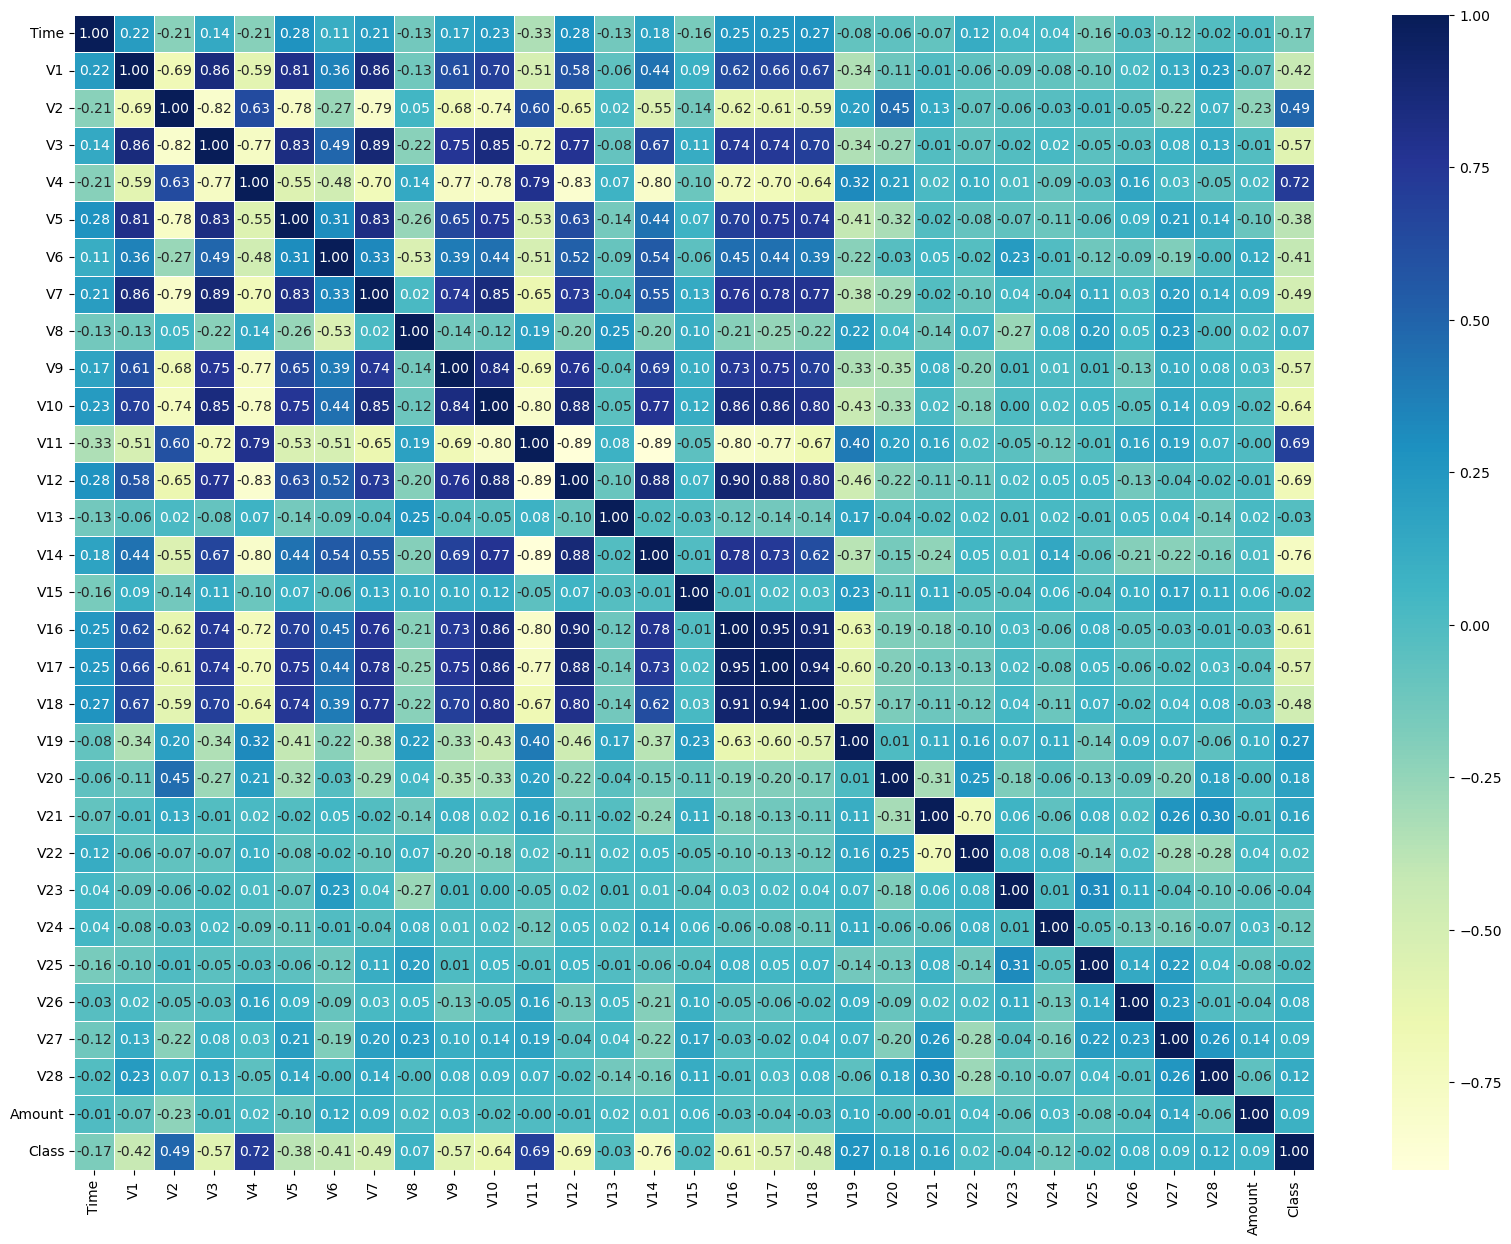

In [23]:
# correlation matrics to know the magnitude to which features in the DataFrame correlate with each other
# this is necessary to know how effective our model can be at finding patterns to for future new data predictions
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True,
            linewidths=0.5, fmt=".2f", cmap="YlGnBu");
plt.show()

the darker the colour, the more the magnitude of correlation between the variables and vise versa 

In [24]:
train_resampled = x_resampled
train_resampled["Class"].value_counts()

Class
0    437
1    394
Name: count, dtype: int64

In [25]:
# checking for nan values
print(f"Total missing values in the DataFrame:{train_resampled.isnull().sum().sum()}")

Total missing values in the DataFrame:0


In [26]:
# let's put our models in a dictionary and create a function which fits the model on training data and scores them on valid data.
models = {
    "Xgboost": XGBClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1)
}

def fit_and_score(models, x_train, x_valid, y_train, y_valid):
    """
    Fits and evaluates sklearn machine learning model
    models: dict of sklearn machine learning model
    x_train: data set of the independent variables for training a machine learning model
    x_valid: data set of the independent varibales for evaluation of machine learning model
    y_train: data set of the dependent variables associated with the x_train for training
    y_valid: data set of the dependent variables associated with the x_test for evaluation
    """
    # import random seed for reproductibility
    np.random.seed(42)
    # make a list to keep scores
    model_scores = {}
    # loop through the model
    for name, model in models.items():
        model.fit(x_train, y_train)# train the model
        model_scores[name] = model.score(x_valid, y_valid) # Evaluate the model and append the scores
    return model_scores

In [27]:
# import validation data set
valid_df = pd.read_csv("credit_valid.csv")

In [28]:
# splitting train and valid data for Machine learning to find patterns 
x_train = train_resampled.drop("Class", axis=1)
y_train = train_resampled["Class"]

x_valid = valid_df.drop("Class", axis=1)
y_valid = valid_df["Class"]

In [29]:
model_scores = fit_and_score(models=models,x_train=x_train, x_valid=x_valid,
                            y_train=y_train, y_valid=y_valid)

In [30]:
model_scores

{'Xgboost': 0.9652750956778203, 'Random Forest': 0.9797057687581194}

In [31]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare

,Xgboost,Random Forest
Accuracy,0.965275,0.979706


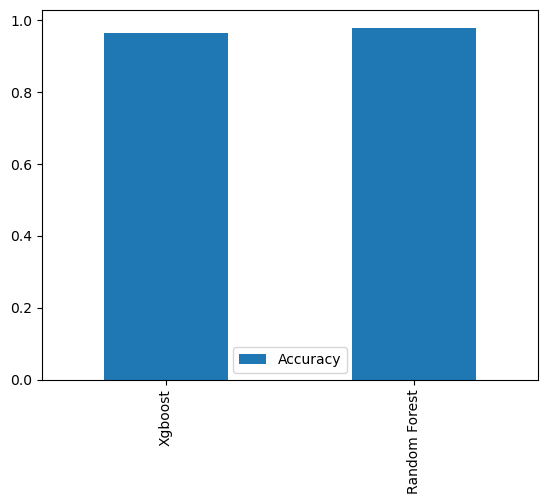

In [32]:
# visualizing model comparison
model_compare.T.plot.bar()
plt.show()

In [33]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Hyperparameter tuning using Randomised search CV and Gridsearch

difference between them is randomized search the parameters exhaustively to find the best parameter for implementation, therefore i'm going to use the best parameter from the randomized searchcv for gridsearch

In [35]:
rf_grid = {
    "n_estimators": [50, 200, 500],  # Lower number of trees to reduce training time
    "max_depth": [None, 5, 10],  # Fewer depth options
    "min_samples_split": [2, 10],  # Fewer values
    "min_samples_leaf": [1, 5],  # Reducing choices
    "max_features": ["sqrt"],  # Only best-known setting to reduce computation
}

xgboost_grid = {
    "n_estimators": [50, 200, 500],  # Fewer boosting rounds
    "max_depth": [3, 6],  # Small values prevent deep trees
    "learning_rate": [0.05, 0.1],  # Only reasonable values
    "subsample": [0.7, 1.0],  # Limited sampling choices
    "colsample_bytree": [0.7, 1.0],  # Fewer feature sampling choices
    "reg_lambda": [1],  # Only standard L2 regularization
    "tree_method": ["hist"],  # Optimized for CPU
}

In [36]:
from sklearn.model_selection import RandomizedSearchCV
# import seed
np.random.seed(42)

# steup hyperparameter search 
rs_rf = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight="balanced"),
                               param_distributions=rf_grid,
                               n_iter=20,
                               cv=5,
                               verbose=True,
                          scoring="recall",random_state=42) # dont miss any fraud case, false postive is preffered 
rs_rf.fit(x_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [37]:
rs_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [38]:
rs_rf.score(x_valid, y_valid)

0.9272727272727272

In [39]:
# import seed
np.random.seed(42)
best_rf_parameter = {'n_estimators': [200],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['sqrt'],
 'max_depth': [None]}

#setup hyperparameter search for Xgb
gs_rf = GridSearchCV(estimator=RandomForestClassifier(class_weight="balanced",random_state=42),
                               param_grid=best_rf_parameter,
                               cv=5,
                               verbose=True,
                    scoring="recall") # dont miss any case
gs_rf.fit(x_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [40]:
y_valid.value_counts()

Class
0    28426
1       55
Name: count, dtype: int64

In [41]:
gs_rf.score(x_valid, y_valid)

0.9272727272727272

#### most evaluation metric for the evaluation are alike as they compare model predictions with the y truth values

In [42]:
y_preds_rf = gs_rf.predict(x_valid)

In [43]:
y_preds_rf

array([0, 0, 0, ..., 1, 0, 0], shape=(28481,))

#### ROC AND AUC

#### ROC(Receiever Operating Characteristics)

The ROC (Receiver Operating Characteristic) curve is a performance evaluation metric for binary classification models. It shows the trade-off between sensitivity (recall) and specificity across different classification thresholds.

#### AUC (Area Under Curve) - Performance Metric

- AUC-ROC Score = Area under the ROC curve (ranges from 0 to 1).
- Higher AUC = Better Model Performance
  
- AUC = 1.0 → Perfect classifier.
- AUC = 0.5 → Random guessing (no predictive power).
- AUC < 0.5 → Worse than random guessing

##### True Positive Rate (TPR) i.eSensitivity / Recall:
Measures how well the model detects the a fraud case(positive cases)

##### False Positive Rate (FPR): 
Measures the proportion of non fraud case instances that were incorrectly classified as a fraud case by the model

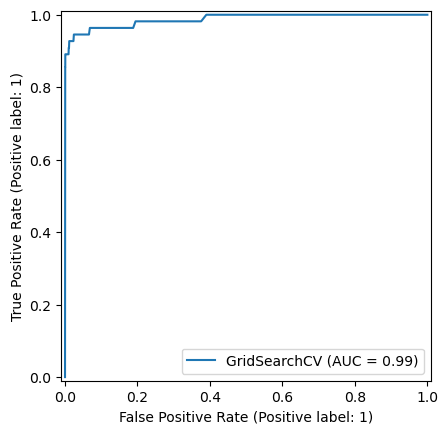

In [44]:
# Plot ROC CURVE
RocCurveDisplay.from_estimator(estimator=gs_rf, 
                              X=x_valid, 
                              y=y_valid);
plt.show();

In [45]:
# create a confusion metrics
print(confusion_matrix(y_valid, y_preds_rf))

[[27860   566]
 [    4    51]]


In [46]:
y_preds_rf

array([0, 0, 0, ..., 1, 0, 0], shape=(28481,))

In [47]:
# lets make it more visual for presentation using heatmap
#Let's create a function which uses Seaborn's heatmap() for doing so

import seaborn as sns
sns.set(font_scale=1.5)# increase font scale

def plot_conf_mat(y_valid, y_preds):
    """
    plot heatmap confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_valid, y_preds), 
                     annot=True, cbar=False)
    plt.xlabel("true values")
    plt.ylabel("predicted value")
    return plt.show();

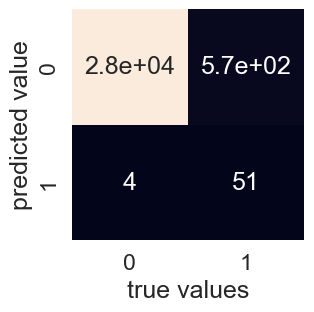

In [48]:
plot_conf_mat(y_valid, y_preds_rf)

In [49]:
print(classification_report(y_valid, y_preds_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28426
           1       0.08      0.93      0.15        55

    accuracy                           0.98     28481
   macro avg       0.54      0.95      0.57     28481
weighted avg       1.00      0.98      0.99     28481



In [50]:
gs_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [51]:
# test model performance with unseen data
test_df = pd.read_csv("credit_test.csv")

In [52]:
test_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,68066.0,0.671643,-0.942028,-0.252469,1.362301,-0.042134,0.903340,0.137444,0.131322,0.721237,...,0.025003,-0.349154,-0.496817,-1.319020,0.680149,-0.210734,-0.006444,0.055433,303.41,0
1,18839.0,-0.613160,0.466776,2.361689,-1.902963,0.103164,-0.175367,0.452681,-0.237162,2.494340,...,-0.201452,0.007555,-0.479154,-0.479811,0.605957,-0.793090,-0.079940,-0.158329,11.85,0


In [53]:
test_df["Class"].value_counts()

Class
0    28438
1       43
Name: count, dtype: int64

In [54]:
x_test_data = test_df.drop("Class", axis=1)
y_test_data = test_df["Class"]

In [55]:
gs_rf.predict(x_test_data)

array([0, 0, 0, ..., 0, 0, 0], shape=(28481,))

In [56]:
y_test_gs_preds = gs_rf.predict(x_test_data)

In [57]:
# True Labels vs. Predicted Labels

precision = precision_score(y_test_data, y_test_gs_preds)  # TP / (TP + FP)
recall = recall_score(y_test_data, y_test_gs_preds)  # TP / (TP + FN)
f1 = f1_score(y_test_data, y_test_gs_preds)  # Harmonic mean of precision & recall

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.0637
Recall: 0.9070
F1 Score: 0.1191


In [58]:
comparing_predictions = {
    "y_true": y_test_data,
    "model predictions": y_test_gs_preds
}

In [59]:
comparing_predictions_df = pd.DataFrame(comparing_predictions)

In [60]:
comparing_predictions_df

,y_true,model predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28476,0,0
28477,0,0
28478,0,0
28479,0,0


In [61]:
comparing_predictions_df.tail(50)

,y_true,model predictions
28431,0,0
28432,0,0
28433,0,0
28434,0,0
28435,0,0
28436,0,0
28437,0,0
28438,0,0
28439,0,0
28440,0,0


In [62]:
import joblib

In [63]:
joblib.dump(gs_rf,"gs_rf.pk1") # save model

['gs_rf.pk1']

In [64]:
#load model
model = joblib.load("gs_rf.pk1")

##### Here is why i prioritized recall over the rest of the metrics

- If missing fraud cases is costly, prioritize recall.(in our case missing fraud cases is costly for the credit card company)
- If false alarms are disruptive, prioritize precision.
- F1-score is useful if you need a balance between the two.

##### Note
  we did reach a proof of concept of 90% recall hence model will be deployed.

### Preparing model for deployment (Streamlit)

In [65]:
#!pip install streamlit

In [66]:
import os
os.getcwd()  # This shows your current working directory

'C:\\Users\\TRANSFER PC2\\Desktop\\global_finance_database'

In [67]:
!pip install joblib

In [68]:
!pip install scikit-learn

In [70]:
%%writefile app.py

import streamlit as st
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import io  # Import io for capturing df.info()

# Set page configuration (must be the first Streamlit command)
st.set_page_config(page_title="Credit Card Fraud Detection", layout="wide")


# Load the saved model
@st.cache_resource
def load_model():
    return joblib.load("gs_rf.pk1")  # Ensure the file exists in the directory

model = load_model()

# Streamlit UI
st.title("Credit Card Fraud Detection System")
st.write(
    """
    This is a demo for predicting credit card fraud using a machine learning model, the dataset used 
    for this demo was obtained from Kaggle. The features have been anonymized due to company data privacy 
    policies, recall is at 90% (i.e don't miss any fraud case). Email me at nosakhareasowata94@gmail.com for feedback/remarks 
    as i will be updating my code from the feedbacks i get, thanks in anticipation.
    """
)

st.write("### Download Test File (CSV Format) and make your predictions")
csv_url = "https://docs.google.com/spreadsheets/d/1K3jIpRLh-dwtmMPOD3RsN5k08IJdtRIW-CvH3ETxwt4/export?format=csv"
st.markdown(f"[Download CSV File]({csv_url})")

st.write("### Download Test File results (CSV Format) and compare with model predictions")
csv_url = "https://docs.google.com/spreadsheets/d/1ykMCpFcpVFINL_GPGU_No3t6id85DvLlob1-axWj7ys/export?format=csv"
st.markdown(f"[Download CSV File]({csv_url})")

# File uploader
uploaded_file = st.file_uploader("Choose a CSV file to predict fraud cases", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    
    st.write("### Uploaded Data Preview:")
    st.dataframe(df.head())  # Display the uploaded data as a dataframe

    # Show data information (columns, types, etc.)
    st.write("### Data Information:")
    buffer = io.StringIO()  # Use StringIO to capture df.info() output
    df.info(buf=buffer)
    info_str = buffer.getvalue()
    st.text(info_str)

    # Ensure the dataset has the correct features
    expected_features = model.feature_names_in_  # Extract features the model expects
    if all(feature in df.columns for feature in expected_features):
        # Make predictions
        predictions = model.predict(df[expected_features])
        
        # Add fraud prediction to dataframe with 1 for fraud, 0 for non-fraud
        df["Fraud_Prediction"] = predictions
        df["Fraud_Label"] = df["Fraud_Prediction"].apply(lambda x: "Fraud" if x == 1 else "Non-Fraud")

        st.write("### Predictions and Label Counts:")
        st.write(df["Fraud_Label"].value_counts())
        
        # Plot categorical comparisons
        st.write("### Comparison between Categorical Features:")
        categorical_features = df.select_dtypes(include=['object']).columns
        if len(categorical_features) > 0:
            for feature in categorical_features:
                plt.figure(figsize=(8, 5))
                sns.countplot(x=feature, hue="Fraud_Label", data=df)
                plt.title(f"Comparison of {feature} with Fraud Prediction")
                plt.xticks(rotation=45)
                st.pyplot(plt)
        
        # Allow users to download the predictions
        csv = df.to_csv(index=False).encode("utf-8")
        st.download_button("Download Predictions with Labels", csv, "predictions_with_labels.csv", "text/csv")
    else:
        st.error("Uploaded CSV does not have the required features for prediction.")


Overwriting app.py
